In [ ]:
%cd drive/MyDrive/others/fma

/content/drive/MyDrive/others/fma


**Transaction-Based Models**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the data
transcations = pd.read_csv('final_transactions_dataset.csv')
# print(transcations.shape)

label_encoder = LabelEncoder()
transcations['company'] = label_encoder.fit_transform(transcations['company'])
transcations['sector'] = label_encoder.fit_transform(transcations['sector'])
transcations['date_BUY_fix'] = pd.to_datetime(transcations['date_BUY_fix'])
transcations['date_SELL_fix'] = pd.to_datetime(transcations['date_SELL_fix'])

transcations['buy_year'] = transcations['date_BUY_fix'].dt.year
transcations['sell_year'] = transcations['date_SELL_fix'].dt.year
transcations['buy_month'] = transcations['date_BUY_fix'].dt.month
transcations['sell_month'] = transcations['date_SELL_fix'].dt.month

# use the transcations before 2017-01-01 as training data
train = transcations[transcations['date_BUY_fix'] < '2017-01-01']
test = transcations[transcations['date_BUY_fix'] >= '2017-01-01']

# print('train.shape:', train.shape)
# print('test.shape:', test.shape)

train_x = train.drop(['date_SELL_fix', 'date_BUY_fix', 'investment', 'expected_return (yearly)', 'nominal_return', 'price_SELL', 'Volatility_sell'], axis=1)
train_y = train['investment'].map({'GOOD': 1, 'BAD': 0})

test_x = test.drop(['date_SELL_fix', 'date_BUY_fix', 'investment', 'expected_return (yearly)', 'nominal_return', 'price_SELL', 'Volatility_sell'], axis=1)
test_y = test['investment'].map({'GOOD': 1, 'BAD': 0})

XAI

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.5 MB/s eta 0:00:00


Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

logistic_model = LogisticRegression(max_iter=1000)

logistic_model.fit(train_x_scaled, train_y)
predictions = logistic_model.predict(test_x_scaled)

accuracy = accuracy_score(test_y, predictions)
print(f'Accuracy: {accuracy:.4f}')

# f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_y, predictions)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.6110
F1 Score: 0.0038


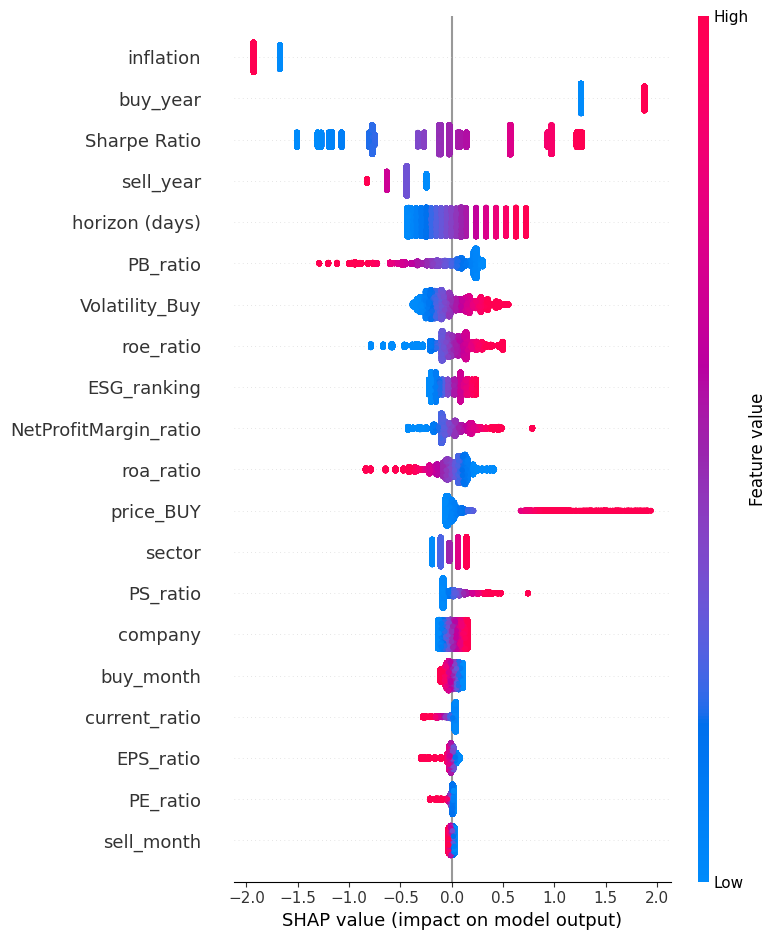

In [ ]:
import shap
explainer = shap.Explainer(logistic_model, train_x_scaled)
shap_values = explainer(test_x_scaled)
shap.summary_plot(shap_values, test_x_scaled, feature_names=train_x.columns)

Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

random_forest_model = RandomForestClassifier(random_state=0)
random_forest_model.fit(train_x, train_y)
predictions = random_forest_model.predict(test_x)

accuracy = accuracy_score(test_y, predictions)
print(f'Accuracy: {accuracy:.4f}')

# f1 score
from sklearn.metrics import f1_score
f1 = f1_score(test_y, predictions)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.5557
F1 Score: 0.0033


Neural Network

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(42)
tf.random.set_seed(42)

# Scale the features
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

model = Sequential([
    Dense(64, activation='relu', input_shape=(train_x_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_x_scaled, train_y, epochs=1, batch_size=32)

# Evaluation: accuracy and f1-score
loss, accuracy = model.evaluate(test_x_scaled, test_y)
print(f'Neural Network Accuracy: {accuracy:.4f}')

pred_probabilities = model.predict(test_x_scaled)
pred_labels = (pred_probabilities > 0.5).astype(int)
f1 = f1_score(test_y, pred_labels)
print(f'F1 Score: {f1:.2f}')

1892/1892 [==============================] - 3s 1ms/step - loss: 0.9393 - accuracy: 0.6945
Neural Network Accuracy: 0.6945
1892/1892 [==============================] - 3s 2ms/step
F1 Score: 0.00


In [ ]:
import shap
import numpy as np

explainer = shap.KernelExplainer(model.predict, shap.sample(train_x_scaled, 100))  # randomly sample 100

# Compute SHAP values
shap_values = explainer.shap_values(shap.sample(test_x_scaled, 100))

shap_values_squeezed = np.squeeze(shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_squeezed[0], test_x.iloc[0])

4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6538/6538 [==============================] - 8s 1ms/step


**Time-Series Based Models**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# read the data
data = pd.read_csv("sorted_final_transactions_dataset.csv")
data['date_BUY_fix'] = pd.to_datetime(data['date_BUY_fix'])
data.sort_values(by='date_BUY_fix', inplace=True)

# group by company
grouped_data = data.groupby('company')

# time stamp for prediction
forecast_periods = [90, 180, 270, 365]

ARIMA Model

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=647.820, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=644.444, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=645.823, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=645.789, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=643.801, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=647.521, Time=1.62 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 6.341 seconds
Company: 1
Predictions:
90 days later: 27.42
180 days later: 27.42
270 days later: 27.42
365 days later: 27.42

MSE for company 1: 204.81



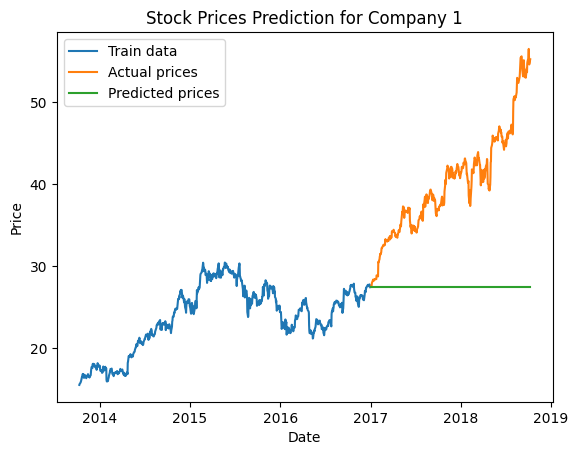

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5932.454, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5931.901, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5933.768, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5933.772, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5932.535, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5935.759, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.659 seconds
Company: 2
Predictions:
90 days later: 799.65
180 days later: 849.43
270 days later: 899.21
365 days later: 951.75

MSE for company 2: 246388.96



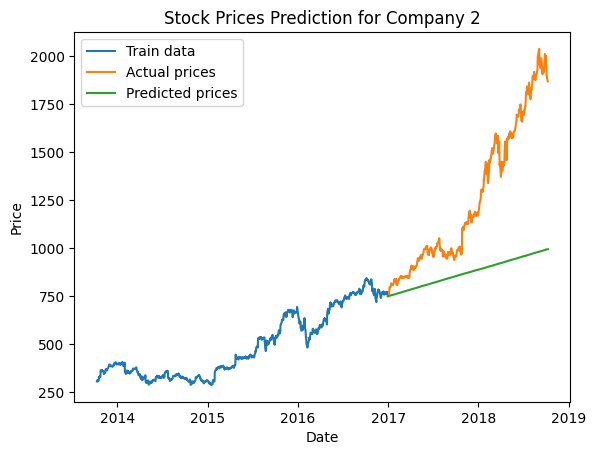

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2156.253, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2154.331, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2152.230, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2152.199, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2152.340, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2154.199, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2154.199, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2156.199, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2150.207, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2152.207, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2152.207, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2150.238, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2154.207, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.186 seconds
Company: 3
Predictions

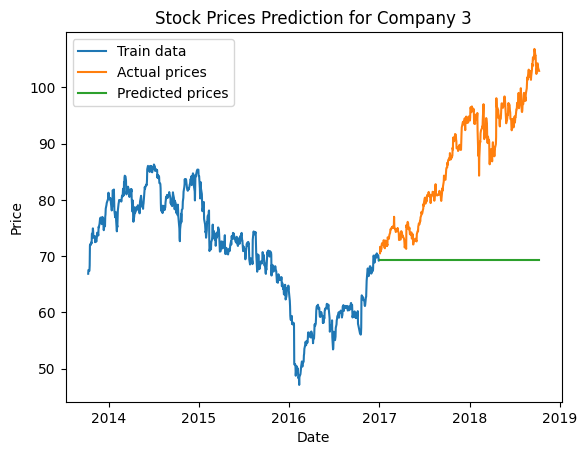

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-40.071, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-34.008, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-35.673, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36.048, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.688, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-35.045, Time=1.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-32.663, Time=2.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-35.479, Time=2.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36.927, Time=0.71 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-33.407, Time=1.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-33.505, Time=0.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-30.387, Time=2.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-40.824, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-35.810, 

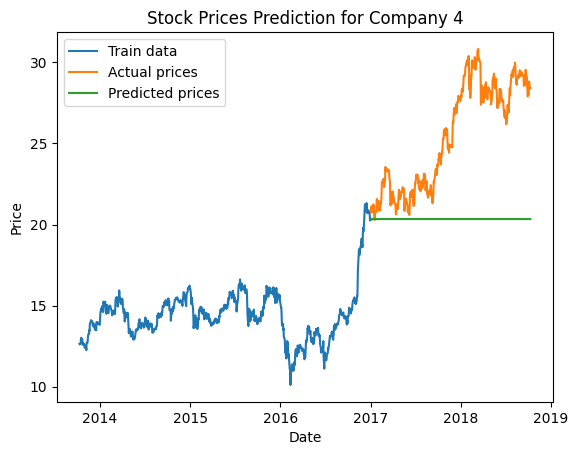

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1742.249, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1744.092, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1744.081, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1740.369, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1745.809, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.779 seconds
Company: 5
Predictions:
90 days later: 38.41
180 days later: 38.41
270 days later: 38.41
365 days later: 38.41

MSE for company 5: 504.59



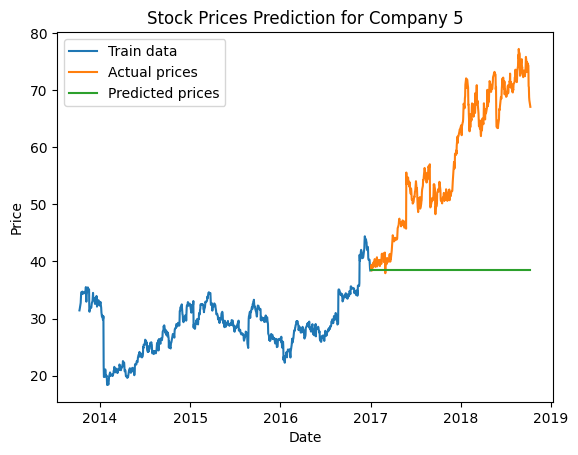

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2723.036, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2724.803, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2724.783, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2722.613, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2726.666, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.969 seconds
Company: 6
Predictions:
90 days later: 144.02
180 days later: 144.02
270 days later: 144.02
365 days later: 144.02

MSE for company 6: 1380.66



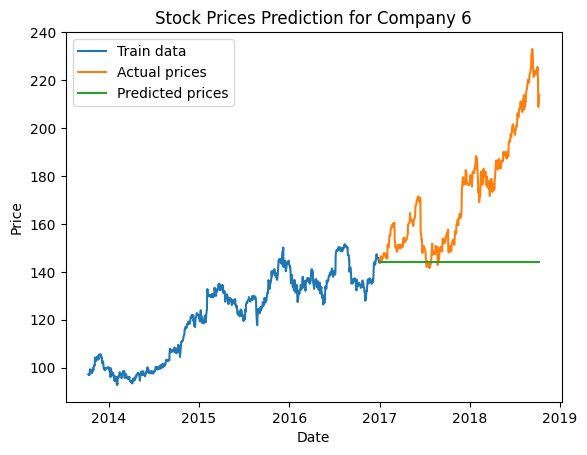

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1297.249, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1300.119, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1302.021, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1302.028, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1300.625, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1304.643, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1304.741, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1301.261, Time=2.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1301.400, Time=2.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1303.638, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1306.349, Time=0.72 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1306.493, Time=0.67 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1301.067, Time=2.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1297.614, Time=1.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)

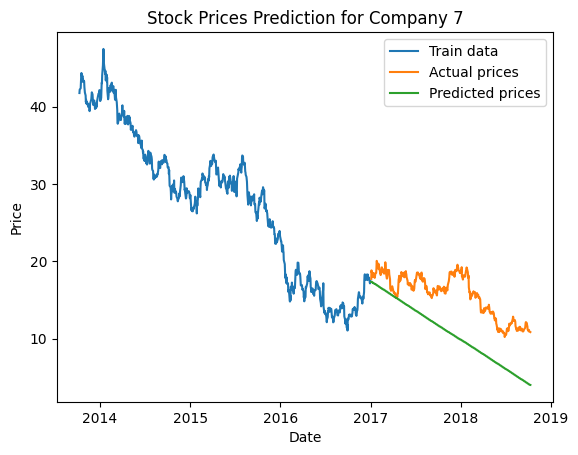

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-696.471, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-700.662, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-700.472, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-698.257, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-698.770, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-698.747, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-698.345, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-702.484, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-700.595, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-700.572, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-702.290, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-700.168, Time=0.44 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.070 seconds
Company: 8
Predictions:
90 

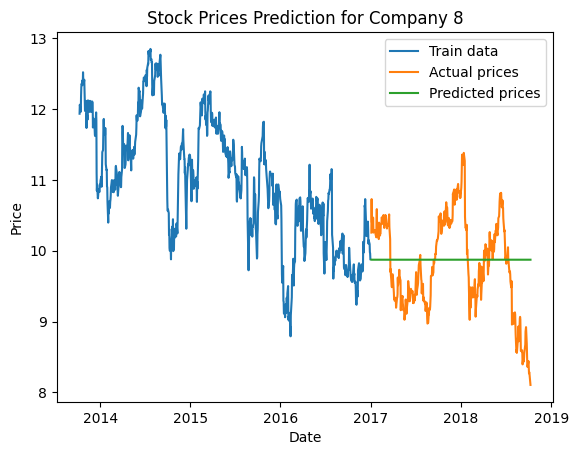

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3043.525, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3049.311, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3050.749, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3050.728, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3049.404, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3043.287, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3052.507, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3052.708, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3040.159, Time=0.56 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3042.502, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3042.096, Time=0.82 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3041.956, Time=2.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3040.800, Time=0.71 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3040.044, Time=3.05 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

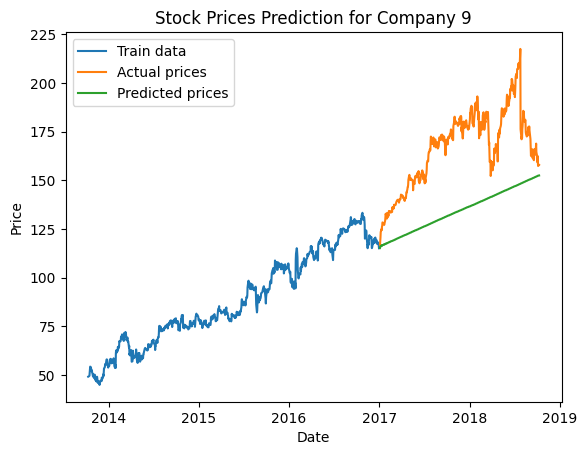

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=894.215, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=895.592, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=895.643, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=892.303, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=897.288, Time=1.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.143 seconds
Company: 10
Predictions:
90 days later: 30.47
180 days later: 30.47
270 days later: 30.47
365 days later: 30.47

MSE for company 10: 27.53



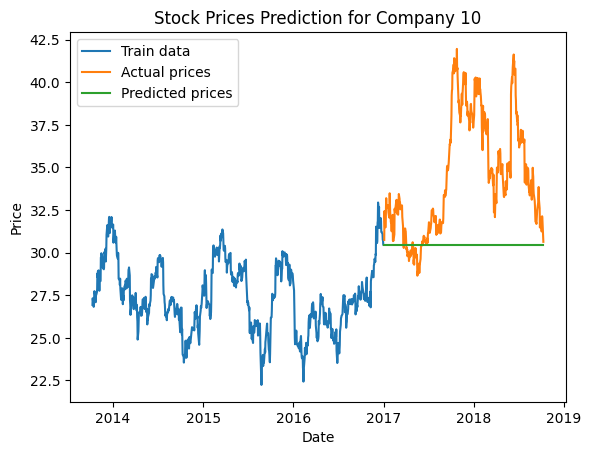

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3897.253, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3895.623, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3895.728, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3895.694, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3894.681, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3897.693, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.441 seconds
Company: 11
Predictions:
90 days later: 771.82
180 days later: 771.82
270 days later: 771.82
365 days later: 771.82

MSE for company 11: 73681.33



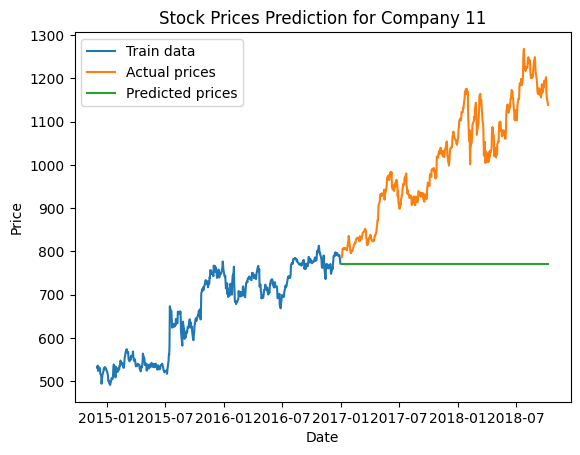

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=987.187, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=988.764, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=988.772, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=985.903, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=990.589, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.976 seconds
Company: 12
Predictions:
90 days later: 29.19
180 days later: 29.19
270 days later: 29.19
365 days later: 29.19

MSE for company 12: 10.17



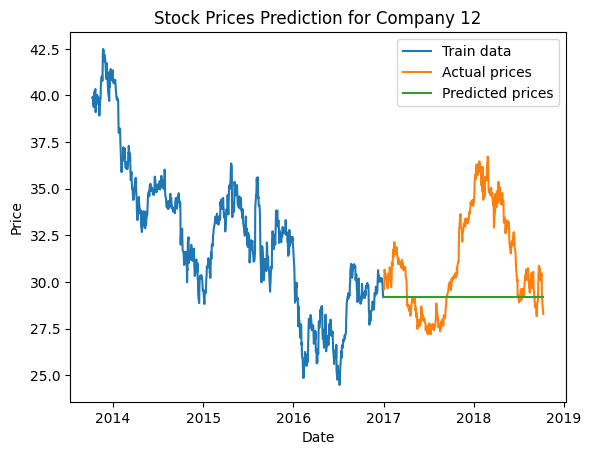

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2053.017, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2053.353, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2054.158, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2053.976, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2051.358, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2050.399, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2051.246, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2051.274, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2051.713, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2052.706, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2048.408, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2051.981, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2052.163, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2049.255, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]          

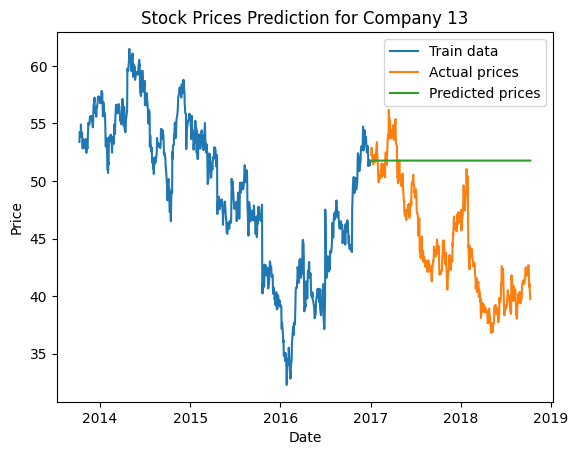

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1751.875, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1749.738, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1750.574, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1750.482, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1750.479, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1748.717, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1750.556, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1750.561, Time=0.73 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1751.216, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1751.485, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1749.321, Time=0.37 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.395 seconds
Company: 14
Predictions:
90 days later: 80.42
180 days later: 84.19
270 days later: 87.97
365 days later: 91.95

MSE for company 14: 75.97



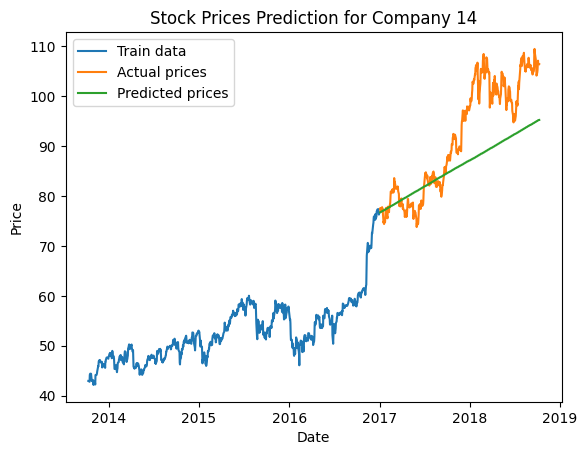

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=441.226, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=443.085, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=443.071, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=439.733, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=439.502, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=443.886, Time=0.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=443.819, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=443.298, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=443.213, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=438.998, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=441.593, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=441.606, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=442.425, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=442.362, 

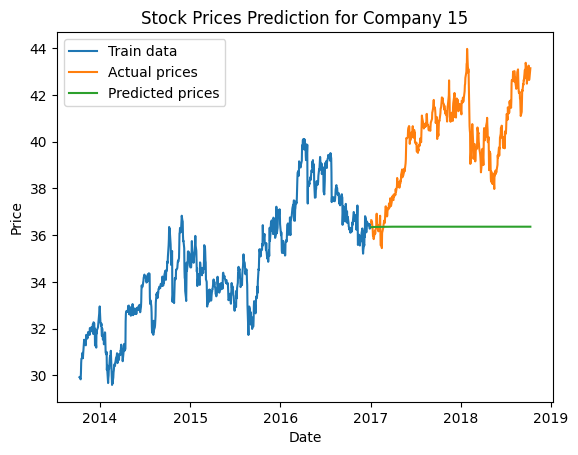

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2019.383, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2020.615, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2022.529, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2022.519, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2018.625, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2023.373, Time=1.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.495 seconds
Company: 16
Predictions:
90 days later: 41.49
180 days later: 41.49
270 days later: 41.49
365 days later: 41.49

MSE for company 16: 222.81



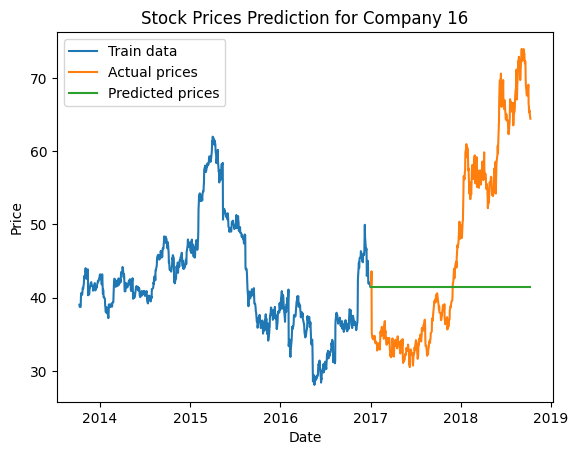

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1670.694, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1666.885, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1667.073, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1666.962, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1664.908, Time=0.04 sec


KeyboardInterrupt: 

In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')


for company, company_data in grouped_data:
    company_data = company_data.drop_duplicates(subset=['date_BUY_fix'])

    # training and testing set split
    train_data = company_data[company_data['date_BUY_fix'] < '2017-01-01']
    test_data = company_data[company_data['date_BUY_fix'] >= '2017-01-01']

    if len(train_data) < 20 or len(test_data) < 1:
        print(f"Insufficient data for company {company}. Skipping...")
        continue

    # ARIMA model
    model = auto_arima(train_data['price_BUY'], seasonal=False, trace=True)

    fitted_model = model.fit(train_data['price_BUY'])

    # make prediction
    forecasts = []
    for period in forecast_periods:
        forecast = fitted_model.predict(n_periods=period).iloc[-1]
        forecasts.append(forecast)

    print(f"Company: {company}")
    print("Predictions:")
    for period, forecast in zip(forecast_periods, forecasts):
        print(f"{period} days later: {forecast:.2f}")
    print()

    actual_prices = test_data['price_BUY']
    mse = mean_squared_error(actual_prices, fitted_model.predict(n_periods=len(actual_prices)))
    print(f"MSE for company {company}: {mse:.2f}")
    print()

    # visualization
    plt.plot(train_data['date_BUY_fix'], train_data['price_BUY'], label='Train data')
    plt.plot(test_data['date_BUY_fix'], actual_prices, label='Actual prices')
    plt.plot(test_data['date_BUY_fix'], fitted_model.predict(n_periods=len(actual_prices)), label='Predicted prices')
    plt.title(f"Stock Prices Prediction for Company {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

Epoch 1/20
12/12 - 4s - loss: 0.1868 - val_loss: 0.5531 - 4s/epoch - 371ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1454 - val_loss: 0.4948 - 117ms/epoch - 10ms/step
Epoch 3/20
12/12 - 0s - loss: 0.1149 - val_loss: 0.4390 - 99ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0876 - val_loss: 0.3822 - 113ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0683 - val_loss: 0.3327 - 105ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0630 - val_loss: 0.2971 - 109ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0621 - val_loss: 0.2747 - 143ms/epoch - 12ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0625 - val_loss: 0.2646 - 111ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0618 - val_loss: 0.2611 - 102ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0605 - val_loss: 0.2579 - 107ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0590 - val_loss: 0.2525 - 113ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0577 - val_loss: 0.2461 - 109ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s - 

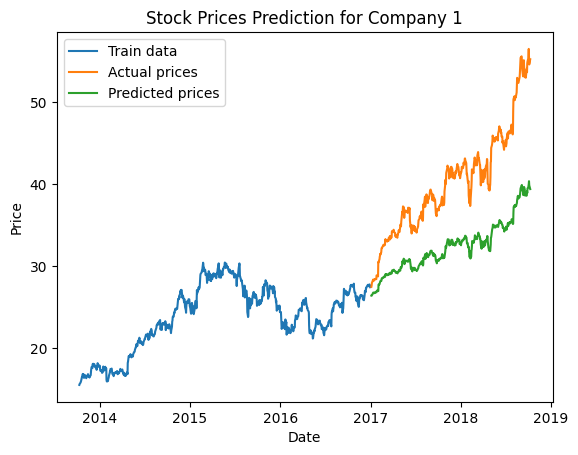

Epoch 1/20
12/12 - 3s - loss: 0.1075 - val_loss: 0.5321 - 3s/epoch - 213ms/step
Epoch 2/20
12/12 - 0s - loss: 0.0866 - val_loss: 0.4948 - 72ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0805 - val_loss: 0.4686 - 82ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0789 - val_loss: 0.4493 - 68ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0773 - val_loss: 0.4327 - 78ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0763 - val_loss: 0.4189 - 82ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0751 - val_loss: 0.4065 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0737 - val_loss: 0.3944 - 77ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0721 - val_loss: 0.3820 - 83ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0704 - val_loss: 0.3690 - 90ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0687 - val_loss: 0.3554 - 112ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0668 - val_loss: 0.3412 - 149ms/epoch - 12ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0

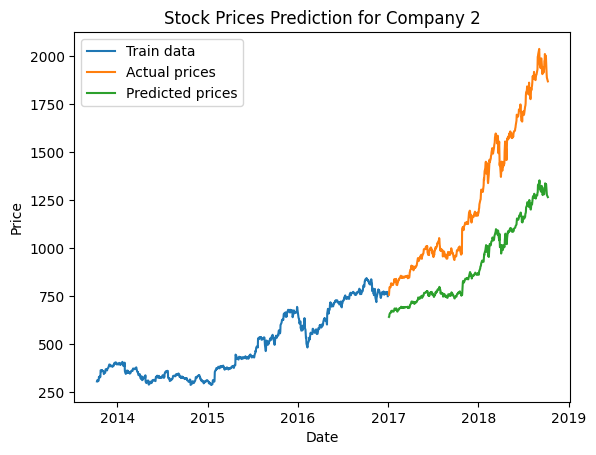

Epoch 1/20
12/12 - 3s - loss: 0.3453 - val_loss: 0.5519 - 3s/epoch - 245ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2906 - val_loss: 0.4821 - 109ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2339 - val_loss: 0.4056 - 100ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1791 - val_loss: 0.3243 - 98ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1394 - val_loss: 0.2460 - 149ms/epoch - 12ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1097 - val_loss: 0.1796 - 101ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0925 - val_loss: 0.1422 - 113ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0837 - val_loss: 0.1360 - 99ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0798 - val_loss: 0.1392 - 92ms/epoch - 8ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0782 - val_loss: 0.1416 - 90ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0779 - val_loss: 0.1382 - 87ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0765 - val_loss: 0.1325 - 90ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 

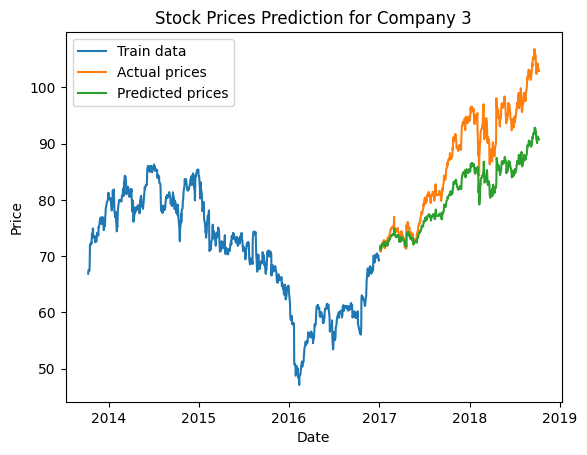

Epoch 1/20
12/12 - 3s - loss: 0.1843 - val_loss: 0.6529 - 3s/epoch - 215ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1408 - val_loss: 0.5867 - 73ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0977 - val_loss: 0.5166 - 82ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0616 - val_loss: 0.4462 - 72ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0441 - val_loss: 0.4009 - 78ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0446 - val_loss: 0.3889 - 77ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0438 - val_loss: 0.3903 - 69ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0421 - val_loss: 0.3888 - 73ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0411 - val_loss: 0.3814 - 73ms/epoch - 6ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0403 - val_loss: 0.3720 - 86ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0397 - val_loss: 0.3633 - 68ms/epoch - 6ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0389 - val_loss: 0.3549 - 81ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0382

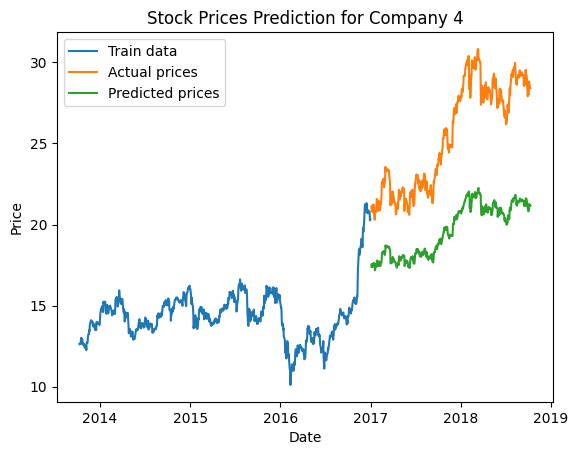

Epoch 1/20
12/12 - 3s - loss: 0.1657 - val_loss: 0.6363 - 3s/epoch - 217ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1284 - val_loss: 0.5811 - 80ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0963 - val_loss: 0.5266 - 68ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0696 - val_loss: 0.4725 - 81ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0556 - val_loss: 0.4290 - 79ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0543 - val_loss: 0.4062 - 81ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0546 - val_loss: 0.3988 - 80ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0535 - val_loss: 0.3960 - 77ms/epoch - 6ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0522 - val_loss: 0.3917 - 71ms/epoch - 6ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0511 - val_loss: 0.3852 - 77ms/epoch - 6ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0503 - val_loss: 0.3774 - 74ms/epoch - 6ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0494 - val_loss: 0.3696 - 70ms/epoch - 6ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0486

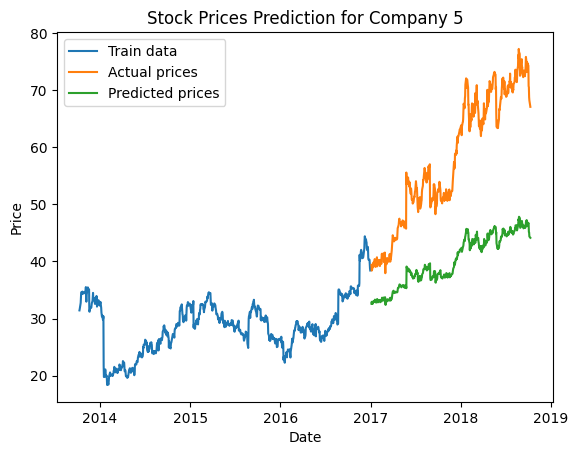

Epoch 1/20
12/12 - 4s - loss: 0.1932 - val_loss: 0.5185 - 4s/epoch - 292ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1559 - val_loss: 0.4668 - 102ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.1337 - val_loss: 0.4207 - 95ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1174 - val_loss: 0.3778 - 109ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1032 - val_loss: 0.3346 - 107ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0892 - val_loss: 0.2900 - 112ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0784 - val_loss: 0.2498 - 110ms/epoch - 9ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0733 - val_loss: 0.2169 - 110ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0737 - val_loss: 0.1992 - 121ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0741 - val_loss: 0.1930 - 89ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0726 - val_loss: 0.1905 - 81ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0702 - val_loss: 0.1867 - 90ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss

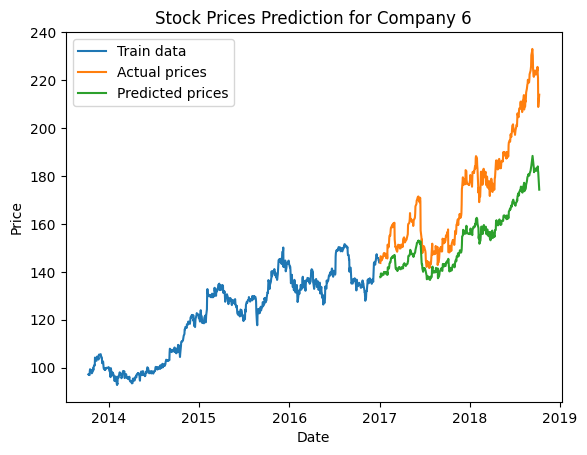

Epoch 1/20
12/12 - 3s - loss: 0.4285 - val_loss: 0.1032 - 3s/epoch - 213ms/step
Epoch 2/20
12/12 - 0s - loss: 0.3733 - val_loss: 0.0753 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.3233 - val_loss: 0.0550 - 74ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 0.2787 - val_loss: 0.0539 - 78ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 0.2432 - val_loss: 0.0777 - 72ms/epoch - 6ms/step
Epoch 6/20
12/12 - 0s - loss: 0.2131 - val_loss: 0.1081 - 81ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1868 - val_loss: 0.1367 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1624 - val_loss: 0.1634 - 81ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1406 - val_loss: 0.1869 - 84ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1225 - val_loss: 0.2023 - 83ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.1116 - val_loss: 0.2031 - 74ms/epoch - 6ms/step
Epoch 12/20
12/12 - 0s - loss: 0.1051 - val_loss: 0.1943 - 76ms/epoch - 6ms/step
Epoch 13/20
12/12 - 0s - loss: 0.1008

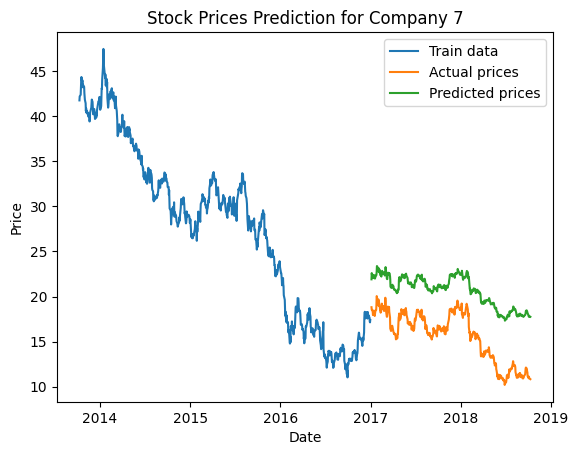

Epoch 1/20
12/12 - 3s - loss: 0.5691 - val_loss: 0.2981 - 3s/epoch - 225ms/step
Epoch 2/20
12/12 - 0s - loss: 0.5047 - val_loss: 0.2449 - 111ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.4379 - val_loss: 0.1914 - 103ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 0.3656 - val_loss: 0.1363 - 102ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 0.2865 - val_loss: 0.0940 - 105ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 0.2061 - val_loss: 0.0846 - 108ms/epoch - 9ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1419 - val_loss: 0.1136 - 118ms/epoch - 10ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1060 - val_loss: 0.1498 - 107ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0923 - val_loss: 0.1589 - 151ms/epoch - 13ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0874 - val_loss: 0.1518 - 114ms/epoch - 9ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0851 - val_loss: 0.1428 - 104ms/epoch - 9ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0843 - val_loss: 0.1374 - 106ms/epoch - 9ms/step
Epoch 13/20
12/12 - 0s -

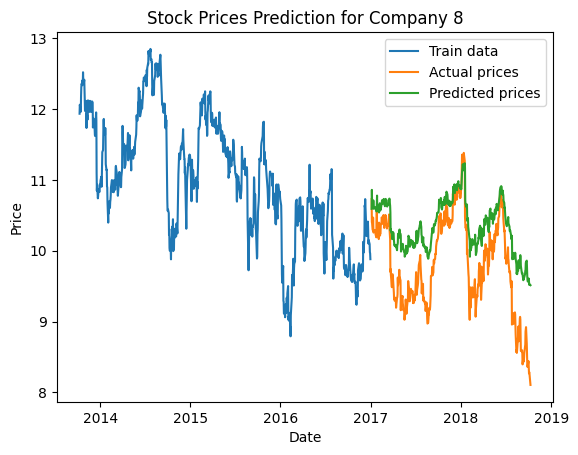

Epoch 1/20
12/12 - 3s - loss: 0.2135 - val_loss: 0.5862 - 3s/epoch - 211ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1682 - val_loss: 0.5194 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.1275 - val_loss: 0.4527 - 76ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0963 - val_loss: 0.3889 - 75ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0813 - val_loss: 0.3429 - 88ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0809 - val_loss: 0.3137 - 75ms/epoch - 6ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0804 - val_loss: 0.2935 - 76ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0792 - val_loss: 0.2772 - 80ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0776 - val_loss: 0.2629 - 82ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0761 - val_loss: 0.2505 - 85ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0745 - val_loss: 0.2401 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0727 - val_loss: 0.2310 - 95ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0707

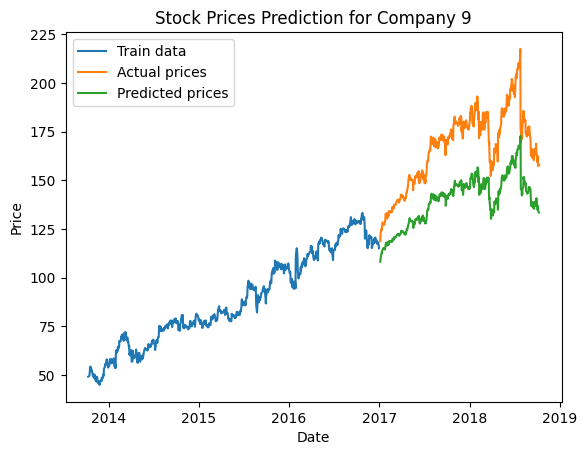

Epoch 1/20
12/12 - 3s - loss: 0.2554 - val_loss: 0.5905 - 3s/epoch - 220ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2101 - val_loss: 0.5306 - 108ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.1641 - val_loss: 0.4670 - 105ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1208 - val_loss: 0.3999 - 130ms/epoch - 11ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0880 - val_loss: 0.3361 - 109ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0720 - val_loss: 0.2906 - 101ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0696 - val_loss: 0.2723 - 150ms/epoch - 13ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0684 - val_loss: 0.2679 - 110ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0667 - val_loss: 0.2667 - 104ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0651 - val_loss: 0.2649 - 120ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0637 - val_loss: 0.2615 - 140ms/epoch - 12ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0625 - val_loss: 0.2566 - 149ms/epoch - 12ms/step
Epoch 13/20
12/12 - 0

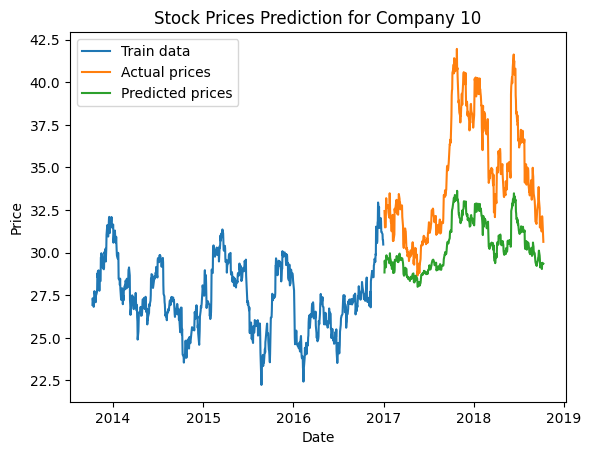

Epoch 1/20
8/8 - 3s - loss: 0.2113 - val_loss: 0.6228 - 3s/epoch - 318ms/step
Epoch 2/20
8/8 - 0s - loss: 0.1800 - val_loss: 0.5789 - 75ms/epoch - 9ms/step
Epoch 3/20
8/8 - 0s - loss: 0.1533 - val_loss: 0.5375 - 76ms/epoch - 10ms/step
Epoch 4/20
8/8 - 0s - loss: 0.1372 - val_loss: 0.5003 - 68ms/epoch - 9ms/step
Epoch 5/20
8/8 - 0s - loss: 0.1246 - val_loss: 0.4651 - 80ms/epoch - 10ms/step
Epoch 6/20
8/8 - 0s - loss: 0.1129 - val_loss: 0.4300 - 75ms/epoch - 9ms/step
Epoch 7/20
8/8 - 0s - loss: 0.1017 - val_loss: 0.3946 - 80ms/epoch - 10ms/step
Epoch 8/20
8/8 - 0s - loss: 0.0922 - val_loss: 0.3603 - 69ms/epoch - 9ms/step
Epoch 9/20
8/8 - 0s - loss: 0.0852 - val_loss: 0.3282 - 72ms/epoch - 9ms/step
Epoch 10/20
8/8 - 0s - loss: 0.0799 - val_loss: 0.2982 - 82ms/epoch - 10ms/step
Epoch 11/20
8/8 - 0s - loss: 0.0761 - val_loss: 0.2713 - 72ms/epoch - 9ms/step
Epoch 12/20
8/8 - 0s - loss: 0.0753 - val_loss: 0.2513 - 68ms/epoch - 8ms/step
Epoch 13/20
8/8 - 0s - loss: 0.0760 - val_loss: 0.2391 - 

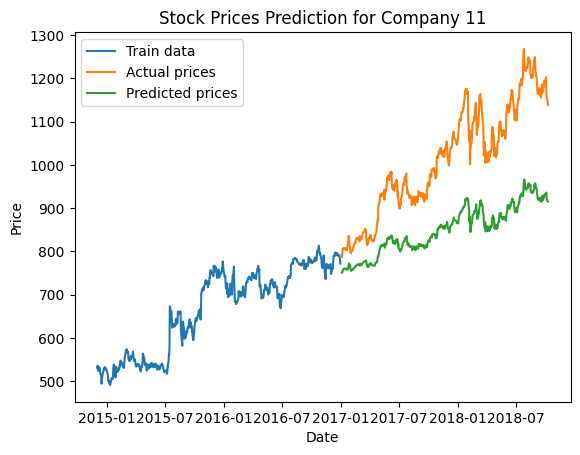

Epoch 1/20
12/12 - 3s - loss: 0.4159 - val_loss: 0.3127 - 3s/epoch - 212ms/step
Epoch 2/20
12/12 - 0s - loss: 0.3569 - val_loss: 0.2544 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2994 - val_loss: 0.1936 - 86ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.2457 - val_loss: 0.1391 - 75ms/epoch - 6ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1981 - val_loss: 0.1030 - 86ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1612 - val_loss: 0.0881 - 87ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1358 - val_loss: 0.0897 - 76ms/epoch - 6ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1221 - val_loss: 0.0918 - 79ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1146 - val_loss: 0.0921 - 87ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1096 - val_loss: 0.0906 - 80ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.1056 - val_loss: 0.0880 - 88ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.1022 - val_loss: 0.0851 - 94ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0992

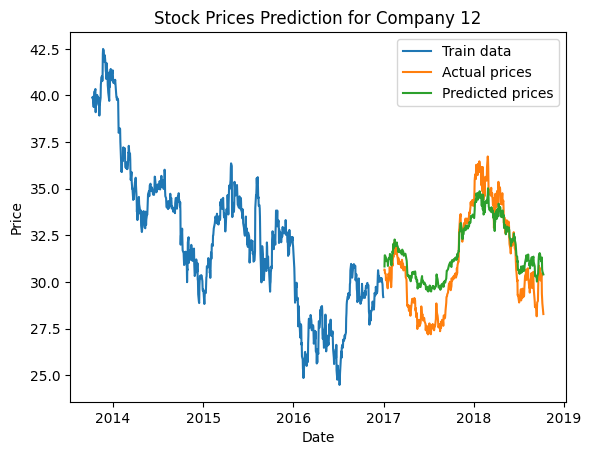

Epoch 1/20
12/12 - 3s - loss: 0.5715 - val_loss: 0.3766 - 3s/epoch - 223ms/step
Epoch 2/20
12/12 - 0s - loss: 0.5080 - val_loss: 0.3176 - 106ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.4424 - val_loss: 0.2544 - 80ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.3731 - val_loss: 0.1873 - 87ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 0.3009 - val_loss: 0.1320 - 100ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.2352 - val_loss: 0.1025 - 81ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1816 - val_loss: 0.1058 - 90ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1430 - val_loss: 0.1237 - 88ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1250 - val_loss: 0.1445 - 83ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1157 - val_loss: 0.1527 - 85ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.1085 - val_loss: 0.1447 - 84ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.1053 - val_loss: 0.1368 - 95ms/epoch - 8ms/step
Epoch 13/20
12/12 - 0s - loss: 0.10

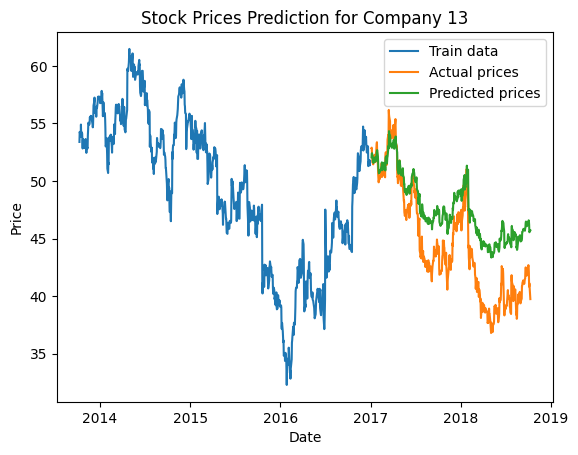

Epoch 1/20
12/12 - 3s - loss: 0.1441 - val_loss: 0.6822 - 3s/epoch - 209ms/step
Epoch 2/20
12/12 - 0s - loss: 0.1016 - val_loss: 0.6174 - 78ms/epoch - 6ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0705 - val_loss: 0.5615 - 81ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0599 - val_loss: 0.5210 - 84ms/epoch - 7ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0599 - val_loss: 0.4955 - 99ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0608 - val_loss: 0.4802 - 89ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0605 - val_loss: 0.4692 - 82ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0594 - val_loss: 0.4594 - 84ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0581 - val_loss: 0.4494 - 101ms/epoch - 8ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0568 - val_loss: 0.4390 - 90ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0555 - val_loss: 0.4280 - 82ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0542 - val_loss: 0.4164 - 89ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.053

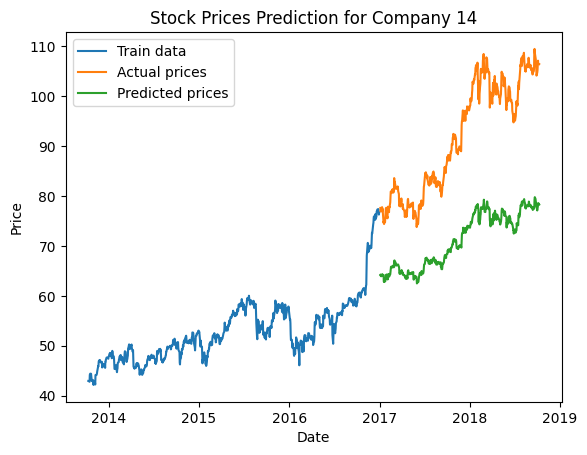

Epoch 1/20
12/12 - 3s - loss: 0.3412 - val_loss: 0.6780 - 3s/epoch - 270ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2924 - val_loss: 0.6135 - 88ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2426 - val_loss: 0.5443 - 93ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1936 - val_loss: 0.4710 - 92ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1484 - val_loss: 0.3954 - 87ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1142 - val_loss: 0.3259 - 86ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0987 - val_loss: 0.2743 - 86ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0975 - val_loss: 0.2437 - 96ms/epoch - 8ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0978 - val_loss: 0.2266 - 83ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0972 - val_loss: 0.2168 - 79ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0958 - val_loss: 0.2109 - 87ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0937 - val_loss: 0.2059 - 79ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0914

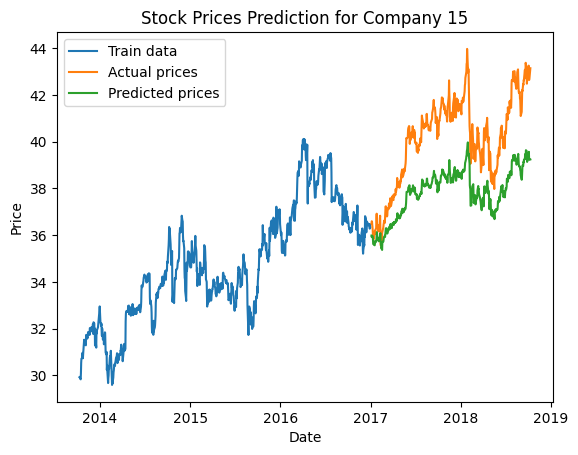

Epoch 1/20
12/12 - 2s - loss: 0.2935 - val_loss: 0.3738 - 2s/epoch - 205ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2477 - val_loss: 0.3220 - 85ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2036 - val_loss: 0.2757 - 76ms/epoch - 6ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1597 - val_loss: 0.2463 - 90ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1247 - val_loss: 0.2273 - 83ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1034 - val_loss: 0.2163 - 80ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0929 - val_loss: 0.2089 - 93ms/epoch - 8ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0895 - val_loss: 0.2051 - 82ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0872 - val_loss: 0.2020 - 89ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0856 - val_loss: 0.1983 - 83ms/epoch - 7ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0841 - val_loss: 0.1940 - 82ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0826 - val_loss: 0.1897 - 87ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0808

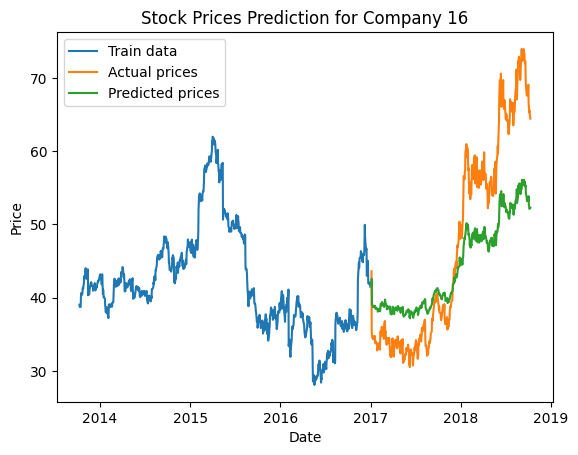

Epoch 1/20
12/12 - 3s - loss: 0.5823 - val_loss: 0.1815 - 3s/epoch - 210ms/step
Epoch 2/20
12/12 - 0s - loss: 0.5171 - val_loss: 0.1388 - 84ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.4491 - val_loss: 0.1098 - 83ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.3745 - val_loss: 0.0905 - 91ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.2914 - val_loss: 0.1015 - 92ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.2129 - val_loss: 0.1365 - 82ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1618 - val_loss: 0.1773 - 93ms/epoch - 8ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1328 - val_loss: 0.2096 - 88ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1144 - val_loss: 0.2306 - 83ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1043 - val_loss: 0.2378 - 92ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0995 - val_loss: 0.2381 - 89ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0960 - val_loss: 0.2347 - 83ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0932

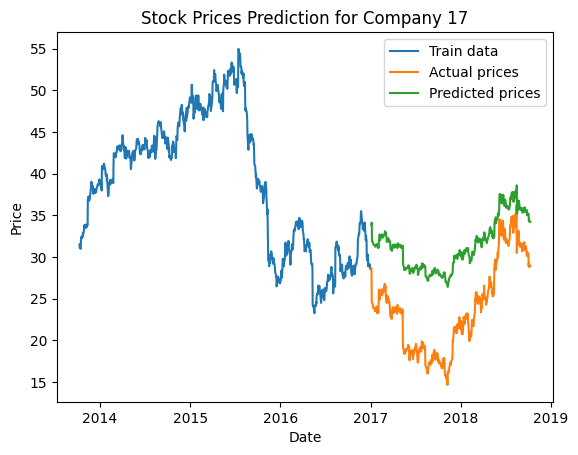

Epoch 1/20
12/12 - 3s - loss: 0.1420 - val_loss: 0.5438 - 3s/epoch - 224ms/step
Epoch 2/20
12/12 - 0s - loss: 0.0996 - val_loss: 0.4818 - 122ms/epoch - 10ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0711 - val_loss: 0.4270 - 108ms/epoch - 9ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0588 - val_loss: 0.3851 - 103ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0593 - val_loss: 0.3628 - 115ms/epoch - 10ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0612 - val_loss: 0.3544 - 139ms/epoch - 12ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0603 - val_loss: 0.3498 - 454ms/epoch - 38ms/step
Epoch 8/20
12/12 - 1s - loss: 0.0585 - val_loss: 0.3440 - 543ms/epoch - 45ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0568 - val_loss: 0.3362 - 160ms/epoch - 13ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0554 - val_loss: 0.3275 - 124ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0542 - val_loss: 0.3186 - 135ms/epoch - 11ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0530 - val_loss: 0.3097 - 106ms/epoch - 9ms/step
Epoch 13/20
12/12 

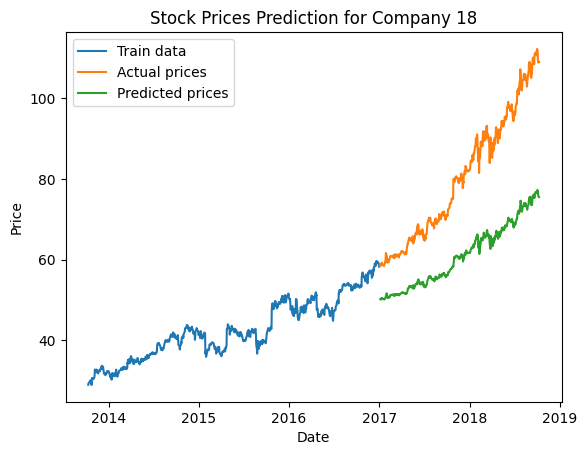

Epoch 1/20
12/12 - 3s - loss: 0.0383 - val_loss: 0.5390 - 3s/epoch - 210ms/step
Epoch 2/20
12/12 - 0s - loss: 0.0425 - val_loss: 0.5194 - 86ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.0438 - val_loss: 0.5111 - 91ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.0423 - val_loss: 0.5048 - 93ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0402 - val_loss: 0.4982 - 91ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0382 - val_loss: 0.4897 - 83ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0362 - val_loss: 0.4769 - 82ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0350 - val_loss: 0.4619 - 89ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0343 - val_loss: 0.4470 - 87ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0333 - val_loss: 0.4316 - 92ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0321 - val_loss: 0.4148 - 84ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0310 - val_loss: 0.3970 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0298

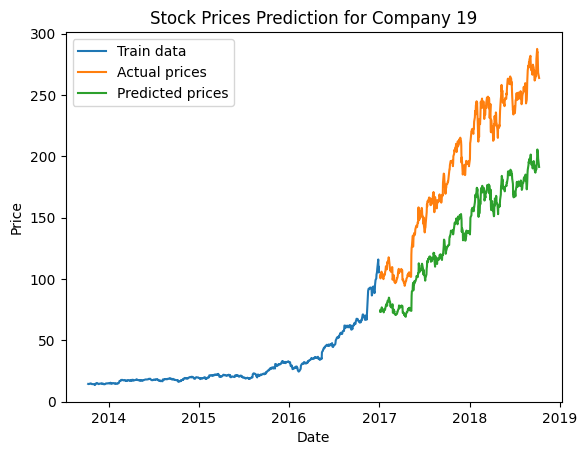

Skipping company 20 due to insufficient data.
Epoch 1/20
12/12 - 3s - loss: 0.3713 - val_loss: 0.7694 - 3s/epoch - 218ms/step
Epoch 2/20
12/12 - 0s - loss: 0.3199 - val_loss: 0.7006 - 82ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2691 - val_loss: 0.6293 - 85ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.2245 - val_loss: 0.5593 - 90ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1860 - val_loss: 0.4888 - 96ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1508 - val_loss: 0.4166 - 92ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1209 - val_loss: 0.3467 - 94ms/epoch - 8ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1016 - val_loss: 0.2871 - 108ms/epoch - 9ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1007 - val_loss: 0.2548 - 103ms/epoch - 9ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1031 - val_loss: 0.2427 - 118ms/epoch - 10ms/step
Epoch 11/20
12/12 - 0s - loss: 0.1021 - val_loss: 0.2384 - 167ms/epoch - 14ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0997 - val_loss: 0.2354 - 119ms/e

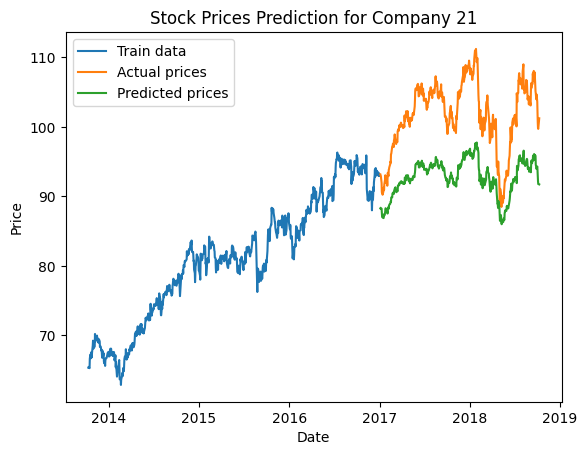

Epoch 1/20
12/12 - 3s - loss: 0.3807 - val_loss: 0.6533 - 3s/epoch - 214ms/step
Epoch 2/20
12/12 - 0s - loss: 0.3194 - val_loss: 0.5752 - 87ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2569 - val_loss: 0.4920 - 95ms/epoch - 8ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1909 - val_loss: 0.4009 - 93ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1287 - val_loss: 0.3082 - 107ms/epoch - 9ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0966 - val_loss: 0.2418 - 85ms/epoch - 7ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0920 - val_loss: 0.2080 - 92ms/epoch - 8ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0938 - val_loss: 0.1941 - 85ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0934 - val_loss: 0.1889 - 89ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0915 - val_loss: 0.1863 - 93ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0890 - val_loss: 0.1833 - 85ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0866 - val_loss: 0.1793 - 85ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.084

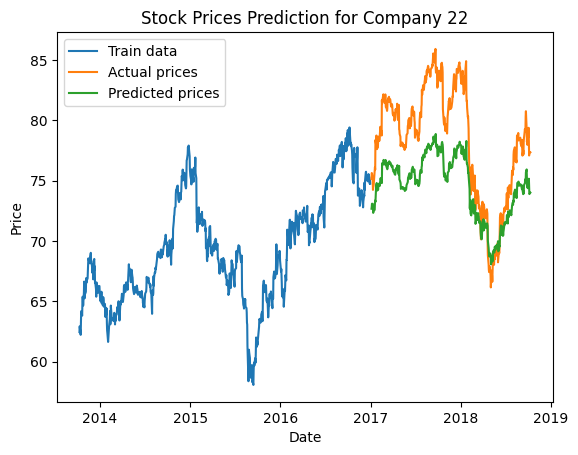

Epoch 1/20
7/7 - 3s - loss: 0.4326 - val_loss: 0.3858 - 3s/epoch - 456ms/step
Epoch 2/20
7/7 - 0s - loss: 0.4035 - val_loss: 0.3567 - 100ms/epoch - 14ms/step
Epoch 3/20
7/7 - 0s - loss: 0.3750 - val_loss: 0.3268 - 89ms/epoch - 13ms/step
Epoch 4/20
7/7 - 0s - loss: 0.3466 - val_loss: 0.2959 - 120ms/epoch - 17ms/step
Epoch 5/20
7/7 - 0s - loss: 0.3204 - val_loss: 0.2645 - 113ms/epoch - 16ms/step
Epoch 6/20
7/7 - 0s - loss: 0.2968 - val_loss: 0.2333 - 110ms/epoch - 16ms/step
Epoch 7/20
7/7 - 0s - loss: 0.2758 - val_loss: 0.2049 - 124ms/epoch - 18ms/step
Epoch 8/20
7/7 - 0s - loss: 0.2587 - val_loss: 0.1798 - 150ms/epoch - 21ms/step
Epoch 9/20
7/7 - 0s - loss: 0.2453 - val_loss: 0.1599 - 87ms/epoch - 12ms/step
Epoch 10/20
7/7 - 0s - loss: 0.2342 - val_loss: 0.1451 - 82ms/epoch - 12ms/step
Epoch 11/20
7/7 - 0s - loss: 0.2250 - val_loss: 0.1338 - 98ms/epoch - 14ms/step
Epoch 12/20
7/7 - 0s - loss: 0.2173 - val_loss: 0.1247 - 116ms/epoch - 17ms/step
Epoch 13/20
7/7 - 0s - loss: 0.2103 - val_l

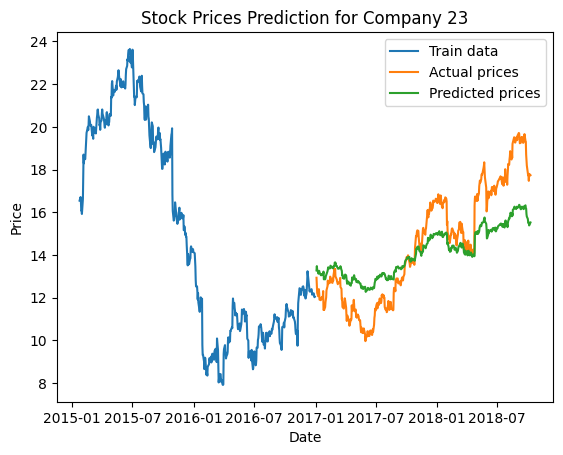

Epoch 1/20
12/12 - 3s - loss: 0.3446 - val_loss: 0.3486 - 3s/epoch - 210ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2908 - val_loss: 0.2940 - 81ms/epoch - 7ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2390 - val_loss: 0.2461 - 82ms/epoch - 7ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1969 - val_loss: 0.2120 - 94ms/epoch - 8ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1695 - val_loss: 0.1879 - 85ms/epoch - 7ms/step
Epoch 6/20
12/12 - 0s - loss: 0.1469 - val_loss: 0.1696 - 91ms/epoch - 8ms/step
Epoch 7/20
12/12 - 0s - loss: 0.1243 - val_loss: 0.1560 - 85ms/epoch - 7ms/step
Epoch 8/20
12/12 - 0s - loss: 0.1059 - val_loss: 0.1467 - 84ms/epoch - 7ms/step
Epoch 9/20
12/12 - 0s - loss: 0.1004 - val_loss: 0.1406 - 84ms/epoch - 7ms/step
Epoch 10/20
12/12 - 0s - loss: 0.1004 - val_loss: 0.1362 - 97ms/epoch - 8ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0987 - val_loss: 0.1319 - 89ms/epoch - 7ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0953 - val_loss: 0.1277 - 86ms/epoch - 7ms/step
Epoch 13/20
12/12 - 0s - loss: 0.0918

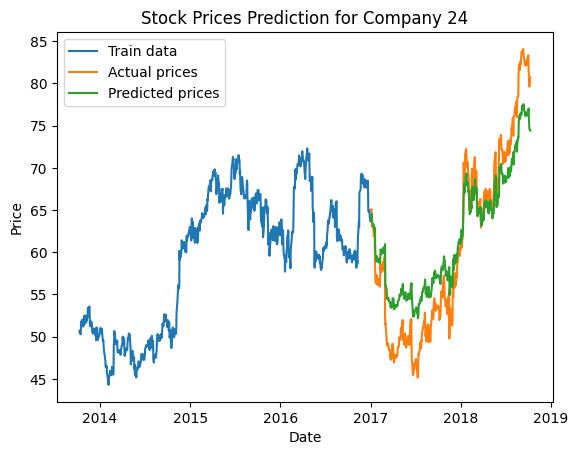

Epoch 1/20
12/12 - 3s - loss: 0.3613 - val_loss: 0.7097 - 3s/epoch - 251ms/step
Epoch 2/20
12/12 - 0s - loss: 0.3074 - val_loss: 0.6382 - 131ms/epoch - 11ms/step
Epoch 3/20
12/12 - 0s - loss: 0.2532 - val_loss: 0.5642 - 117ms/epoch - 10ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1993 - val_loss: 0.4862 - 104ms/epoch - 9ms/step
Epoch 5/20
12/12 - 0s - loss: 0.1442 - val_loss: 0.4016 - 117ms/epoch - 10ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0950 - val_loss: 0.3170 - 141ms/epoch - 12ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0721 - val_loss: 0.2618 - 152ms/epoch - 13ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0700 - val_loss: 0.2495 - 121ms/epoch - 10ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0690 - val_loss: 0.2560 - 159ms/epoch - 13ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0680 - val_loss: 0.2583 - 170ms/epoch - 14ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0671 - val_loss: 0.2529 - 123ms/epoch - 10ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0658 - val_loss: 0.2455 - 125ms/epoch - 10ms/step
Epoch 13/20
12/1

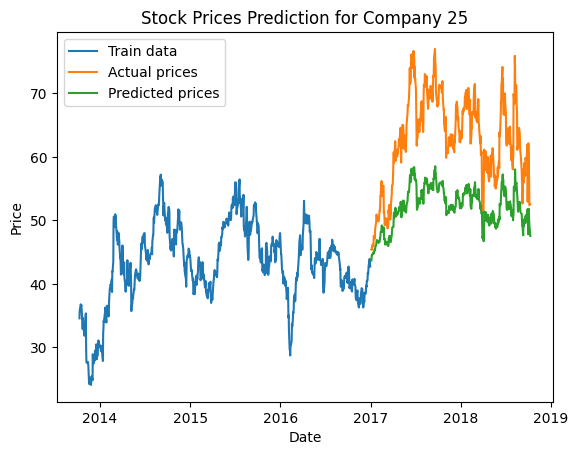

Epoch 1/20
4/4 - 2s - loss: 0.2735 - val_loss: 0.4959 - 2s/epoch - 622ms/step
Epoch 2/20
4/4 - 0s - loss: 0.2581 - val_loss: 0.4770 - 71ms/epoch - 18ms/step
Epoch 3/20
4/4 - 0s - loss: 0.2427 - val_loss: 0.4578 - 72ms/epoch - 18ms/step
Epoch 4/20
4/4 - 0s - loss: 0.2272 - val_loss: 0.4382 - 72ms/epoch - 18ms/step
Epoch 5/20
4/4 - 0s - loss: 0.2114 - val_loss: 0.4183 - 65ms/epoch - 16ms/step
Epoch 6/20
4/4 - 0s - loss: 0.1955 - val_loss: 0.3978 - 70ms/epoch - 17ms/step
Epoch 7/20
4/4 - 0s - loss: 0.1796 - val_loss: 0.3767 - 65ms/epoch - 16ms/step
Epoch 8/20
4/4 - 0s - loss: 0.1637 - val_loss: 0.3551 - 74ms/epoch - 19ms/step
Epoch 9/20
4/4 - 0s - loss: 0.1484 - val_loss: 0.3331 - 65ms/epoch - 16ms/step
Epoch 10/20
4/4 - 0s - loss: 0.1346 - val_loss: 0.3110 - 63ms/epoch - 16ms/step
Epoch 11/20
4/4 - 0s - loss: 0.1228 - val_loss: 0.2895 - 74ms/epoch - 18ms/step
Epoch 12/20
4/4 - 0s - loss: 0.1132 - val_loss: 0.2690 - 74ms/epoch - 18ms/step
Epoch 13/20
4/4 - 0s - loss: 0.1057 - val_loss: 0.

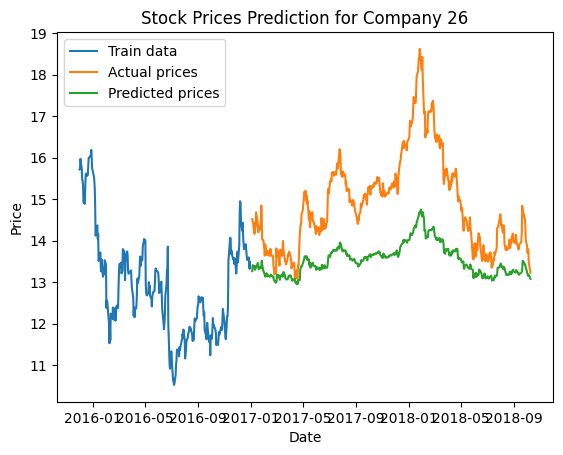

Epoch 1/20
12/12 - 3s - loss: 0.2581 - val_loss: 0.5040 - 3s/epoch - 266ms/step
Epoch 2/20
12/12 - 0s - loss: 0.2117 - val_loss: 0.4446 - 111ms/epoch - 9ms/step
Epoch 3/20
12/12 - 0s - loss: 0.1669 - val_loss: 0.3814 - 115ms/epoch - 10ms/step
Epoch 4/20
12/12 - 0s - loss: 0.1228 - val_loss: 0.3142 - 117ms/epoch - 10ms/step
Epoch 5/20
12/12 - 0s - loss: 0.0850 - val_loss: 0.2489 - 94ms/epoch - 8ms/step
Epoch 6/20
12/12 - 0s - loss: 0.0628 - val_loss: 0.2059 - 117ms/epoch - 10ms/step
Epoch 7/20
12/12 - 0s - loss: 0.0571 - val_loss: 0.2069 - 122ms/epoch - 10ms/step
Epoch 8/20
12/12 - 0s - loss: 0.0548 - val_loss: 0.2144 - 149ms/epoch - 12ms/step
Epoch 9/20
12/12 - 0s - loss: 0.0551 - val_loss: 0.2100 - 121ms/epoch - 10ms/step
Epoch 10/20
12/12 - 0s - loss: 0.0544 - val_loss: 0.2040 - 138ms/epoch - 12ms/step
Epoch 11/20
12/12 - 0s - loss: 0.0534 - val_loss: 0.2011 - 130ms/epoch - 11ms/step
Epoch 12/20
12/12 - 0s - loss: 0.0526 - val_loss: 0.1985 - 128ms/epoch - 11ms/step
Epoch 13/20
12/12 

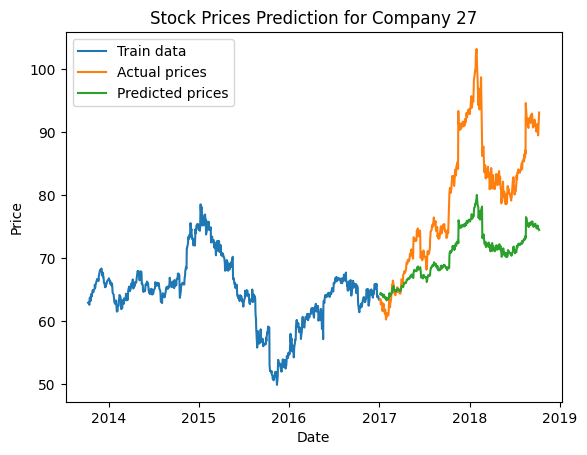

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

for company, company_data in grouped_data:
    company_data = company_data.drop_duplicates(subset=['date_BUY_fix'])

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(company_data[['price_BUY']])

    reframed = series_to_supervised(scaled, 1, 1)

    # Split into train and test sets based on the cutoff date
    train_data = company_data[company_data['date_BUY_fix'] < '2017-01-01']
    test_data = company_data[company_data['date_BUY_fix'] >= '2017-01-01']

    if len(train_data) == 0 or len(test_data) == 0:
        print(f"Skipping company {company} due to insufficient data.")
        continue

    train_scaled = scaler.transform(train_data[['price_BUY']])
    test_scaled = scaler.transform(test_data[['price_BUY']])
    train_reframed = series_to_supervised(train_scaled, 1, 1)
    test_reframed = series_to_supervised(test_scaled, 1, 1)

    train = train_reframed.values
    test = test_reframed.values
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # Check if there is enough data after reframing
    if len(train_X) == 0 or len(test_X) == 0:
        print(f"Skipping company {company} due to insufficient data after reframing.")
        continue

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Design LSTM network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # Fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # report the mse
    from sklearn.metrics import mean_squared_error
    rmse = np.sqrt(mean_squared_error(test_y, yhat))
    print(f'RMSE for company {company}: {rmse:.2f}')

    actual_prices = test_data['price_BUY']

    # NOTE: make alignment for visualization!
    # LSTM will automatically drop the first data point
    test_dates_adjusted = test_data['date_BUY_fix'].iloc[1:].reset_index(drop=True)  # Drop the first date to align with predictions
    actual_prices = test_data['price_BUY'].iloc[1:].reset_index(drop=True)  # Drop the first date to align with predictions

    # plt.figure(figsize=(10, 6))
    plt.plot(train_data['date_BUY_fix'], train_data['price_BUY'], label='Train data')
    plt.plot(test_dates_adjusted, actual_prices, label='Actual prices')
    plt.plot(test_dates_adjusted, inv_yhat, label='Predicted prices')
    plt.title(f"Stock Prices Prediction for Company {company}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()